# Advanced Keras for TPSMAY22

This notebook shows how to train a Keras model. It wouldn't have been possible without the open-source contributions of other participants, in particular:
- [Analysing Interactions with SHAP](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap) where @wti200 shows how to analyze feature interactions
- [EDA & LGBM Model](https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model) where @cabaxiom introduces the unique_characters feature


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import math
import random

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, Concatenate
from tensorflow.keras.utils import plot_model

plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

In [2]:
# Plot training history
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None):
    """Plot (the last n_epochs epochs of) the training history
    
    Plots loss and optionally val_loss and lr."""
    plt.figure(figsize=(15, 6))
    from_epoch = 0 if n_epochs is None else max(len(history['loss']) - n_epochs, 0)
    
    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    try:
        plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')
        best_epoch = np.argmin(np.array(history['val_loss']))
        best_val_loss = history['val_loss'][best_epoch]
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
            almost_val_loss = history['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
    except KeyError:
        pass
    if bottom is not None: plt.ylim(bottom=bottom)
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    if title is not None: plt.title(title)
        
    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        
    plt.show()
    

In [3]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')


# Top three feature interactions

If we look at 2d-scatterplots of the features, colored by target, we find three feature combinations where the projection is subdivided into three distinct regions with sharp borders in between. We can either hope for the neural network to find these borders by itself, or we can help it find them.

And how can we help the neural network? We create three ternary categorical features which indicate in which region a sample is. The following diagrams show the three projections which lead to three regions each:

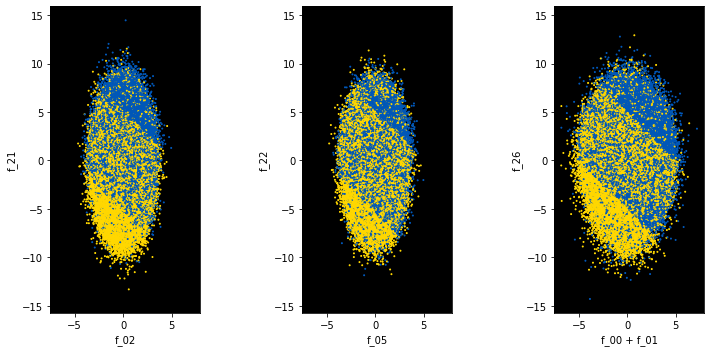

In [4]:
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue


# Feature engineering

We read the data and apply minimal feature engineering:
- We split the `f_27` string into ten separate features as described in the [EDA](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense).
- We count the unique characters in the string.
- We introduce three categorical features for the feature interactions described above.

In [5]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
for df in [train, test]:
    # Extract the 10 letters of f_27 into individual features
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    
    # Feature interactions: create three ternary features
    # Every ternary feature can have the values -1, 0 and +1
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
int_features = [f for f in features if test[f].dtype == int and f.startswith('f')]
ch_features = [f for f in features if f.startswith('ch')]
test[features].head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,1,0,3,11,0,2,5,0,0,1
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,1,0,4,6,2,1,6,0,0,0


# The model

The model is sequential and has four hidden layers. To counter overfitting, I added a kernel_regularizer to all hidden layers.


2022-05-08 21:38:48.664374: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


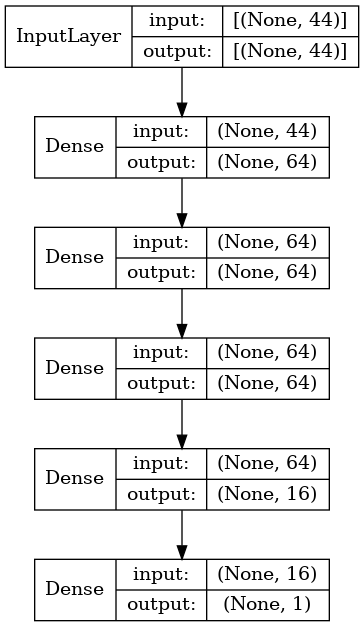

In [6]:
def my_model():
    """Simple sequential neural network with four hidden layers.
    
    Returns a (not yet compiled) instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
    inputs = Input(shape=(len(features)))
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
             )(inputs)
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
             )(x)
    x = Dense(1, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              activation='sigmoid',
             )(x)
    model = Model(inputs, x)
    return model

plot_model(my_model(), show_layer_names=False, show_shapes=True)

# Cross-validation

For cross-validation, we use a simple KFold with five splits. It has turned out that the scores of the five splits are very similar so that I usually run only the first split. This one split is good enough to evaluate the model.

I like to first train the model with early stopping to see what are good initial and final learning rates and the number of epochs, and then I switch to cosine learning rate decay. You can switch back to early stopping anytime by setting the parameter `USE_PLATEAU`.

44 features


2022-05-08 21:38:52.623899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Fold 0.0 | 08:24 | Training loss: 0.0598 | Val loss: 0.0669 | AUC: 0.99801


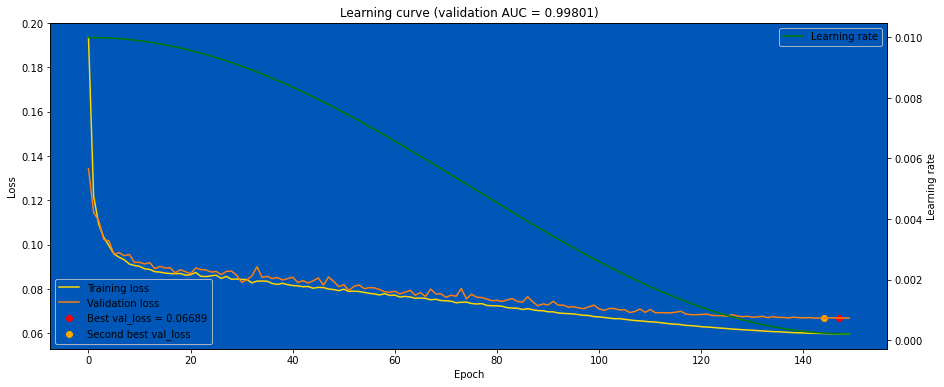

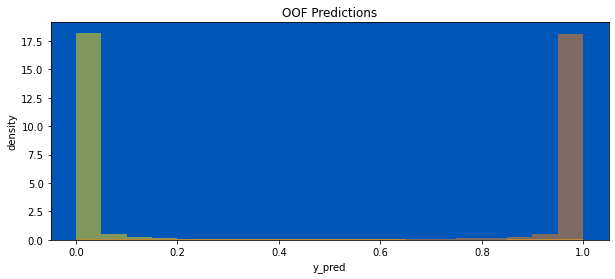

Fold 0.1 | 08:12 | Training loss: 0.0599 | Val loss: 0.0672 | AUC: 0.99801
Fold 0.2 | 08:20 | Training loss: 0.0591 | Val loss: 0.0668 | AUC: 0.99803
Fold 0.3 | 09:24 | Training loss: 0.0602 | Val loss: 0.0669 | AUC: 0.99799
Fold 0.4 | 08:15 | Training loss: 0.0594 | Val loss: 0.0665 | AUC: 0.99804
OOF AUC:                       0.99802
CPU times: user 1h 12min 43s, sys: 11min 12s, total: 1h 23min 55s
Wall time: 42min 39s


In [7]:
%%time
# Cross-validation of the classifier

EPOCHS = 200
EPOCHS_COSINEDECAY = 150
CYCLES = 1
VERBOSE = 0 # set to 0 for less output, or to 2 for more output
DIAGRAMS = True
USE_PLATEAU = False
BATCH_SIZE = 2048
ONLY_FIRST_FOLD = False

# see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

def fit_model(X_tr, y_tr, X_va=None, y_va=None, run=0):
    """Scale the data, fit a model, plot the training history and optionally validate the model
    
    Returns a trained instance of tensorflow.keras.models.Model.
    
    As a side effect, updates y_va_pred, history_list and score_list.
    """
    global y_va_pred
    start_time = datetime.datetime.now()
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    
    if X_va is not None:
        X_va = scaler.transform(X_va)
        validation_data = (X_va, y_va)
    else:
        validation_data = None

    # Define the learning rate schedule and EarlyStopping
    lr_start=0.01
    if USE_PLATEAU and X_va is not None: # use early stopping
        epochs = EPOCHS
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                               patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                           patience=12, 
                           verbose=1,
                           mode="min", 
                           restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    else: # use cosine learning rate decay rather than early stopping
        epochs = EPOCHS_COSINEDECAY
        lr_end = 0.0002
        def cosine_decay(epoch):
            # w decays from 1 to 0 in every cycle
            # epoch == 0                  -> w = 1 (first epoch of cycle)
            # epoch == epochs_per_cycle-1 -> w = 0 (last epoch of cycle)
            epochs_per_cycle = epochs // CYCLES
            epoch_in_cycle = epoch % epochs_per_cycle
            if epochs_per_cycle > 1:
                w = (1 + math.cos(epoch_in_cycle / (epochs_per_cycle-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

        lr = LearningRateScheduler(cosine_decay, verbose=0)
        callbacks = [lr, tf.keras.callbacks.TerminateOnNaN()]
        
    # Construct and compile the model
    model = my_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_start),
                  metrics='AUC',
                  loss=tf.keras.losses.BinaryCrossentropy())

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=validation_data, 
                        epochs=epochs,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)

    history_list.append(history.history)
    callbacks, es, lr, history = None, None, None, None
    
    if X_va is None:
        print(f"Training loss: {history_list[-1]['loss'][-1]:.4f}")
    else:
        lastloss = f"Training loss: {history_list[-1]['loss'][-1]:.4f} | Val loss: {history_list[-1]['val_loss'][-1]:.4f}"
        
        # Inference for validation
        y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=0)
        #oof_list[run][val_idx] = y_va_pred
        
        # Evaluation: Execution time, loss and AUC
        score = roc_auc_score(y_va, y_va_pred)
        print(f"Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}"
              f" | {lastloss} | AUC: {score:.5f}")
        score_list.append(score)
        
        if DIAGRAMS and fold == 0 and run == 0:
            # Plot training history
            plot_history(history_list[-1], 
                         title=f"Learning curve (validation AUC = {score:.5f})",
                         plot_lr=True)

            # Plot y_true vs. y_pred
            plt.figure(figsize=(10, 4))
            plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.xlabel('y_pred')
            plt.ylabel('density')
            plt.title('OOF Predictions')
            plt.show()

    return model, scaler


print(f"{len(features)} features")
history_list = []
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    fit_model(X_tr, y_tr, X_va, y_va)
    if ONLY_FIRST_FOLD: break # we only need the first fold

print(f"OOF AUC:                       {np.mean(score_list):.5f}")

# Three diagrams for model evaluation

We plot the ROC curve just because it looks nice. The area under the red curve is the score of our model.


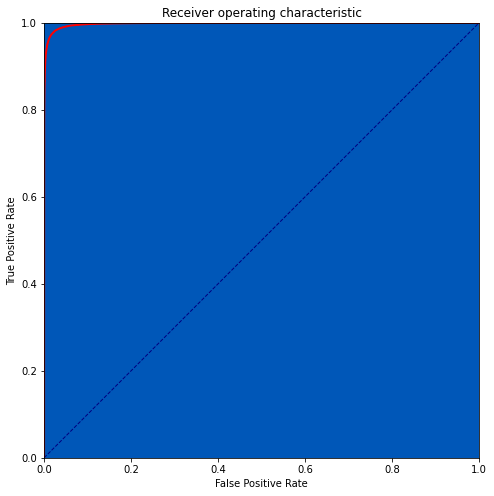

In [8]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

Second, we plot a histogram of the out-of-fold predictions. Many predictions are near 0.0 or near 1.0; this means that in many cases the classifier's predictions have high confidence:

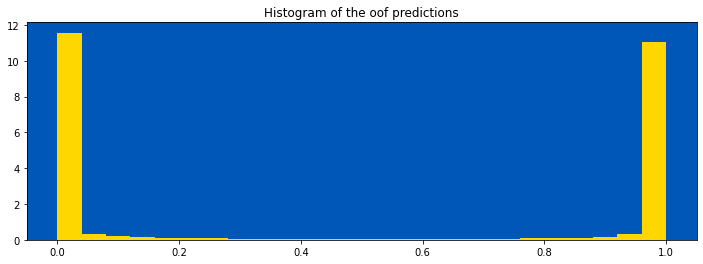

In [9]:
plt.figure(figsize=(12, 4))
plt.hist(y_va_pred, bins=25, density=True)
plt.title('Histogram of the oof predictions')
plt.show()


Finally, we plot the calibration curve. The curve here is almost a straight line, which means that the predicted probabilities are almost exact: 

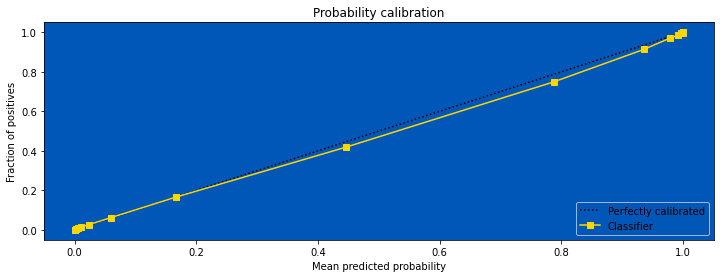

In [10]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

For the submission, we re-train the model on the complete training data with several different seeds and then submit the mean of the predicted ranks.

In [11]:
%%time
# Create submission
print(f"{len(features)} features")

X_tr = train[features]
y_tr = train.target

pred_list = []
for seed in range(10):
    # see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    model, scaler = fit_model(X_tr, y_tr, run=seed)
    pred_list.append(scipy.stats.rankdata(model.predict(scaler.transform(test[features]),
                                                        batch_size=len(test), verbose=0)))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

44 features
Training loss: 0.0602
 0 [625379. 601091.   6366. ... 318472. 146950.   1656.]
Training loss: 0.0597
 1 [476989.5 583104.    5823.  ... 297842.  114893.    2623. ]
Training loss: 0.0601
 2 [6.095300e+05 6.242685e+05 4.815000e+03 ... 3.125980e+05 6.157000e+04
 5.350000e+02]
Training loss: 0.0597
 3 [592017.  575298.5   4687.  ... 296911.  177713.    1710. ]
Training loss: 0.0609
 4 [567384.5 604747.5  72009.  ... 287148.  196854.5   2560. ]
Training loss: 0.0600
 5 [623576.  607203.   28711.  ... 305088.5 100575.    1339. ]
Training loss: 0.0601
 6 [534788.  633534.5  17992.  ... 328405.  127474.    2285. ]
Training loss: 0.0599
 7 [560889.  619163.5   5417.  ... 286371.  149033.    3901. ]
Training loss: 0.0597
 8 [6.73056e+05 5.95868e+05 3.30600e+04 ... 3.17135e+05 1.47577e+05
 6.12000e+02]
Training loss: 0.0599
 9 [472948.5 603339.    4311.  ... 300021.  176613.    2111. ]

CPU times: user 2h 48min 42s, sys: 25min 30s, total: 3h 14min 13s
Wall time: 1h 35min 13s


,id,target
0,900000,573655.75
1,900001,604761.75
2,900002,18319.10
3,900003,139846.65
4,900004,474807.65
...,...,...
699995,1599995,358903.40
699996,1599996,561605.55
699997,1599997,304999.15
699998,1599998,139925.25


# What next?

Now it's your turn! Try to improve this model by
- Changing the network architecture 
- Engineering more features
- Tuning hyperparameters, optimizers, learning rate schedules and so on...

Or, if you prefer gradient boosting, you can have a look at the [Gradient Boosting Quickstart](https://www.kaggle.com/ambrosm/tpsmay22-gradient-boosting-quickstart).
